# Look at results

In [1]:
from utils.utils import *
from utils.plot_utils import *
from utils.data_utils import *
from utils.eval_refusal import *
from utils.attribution_utils import *
from tqdm import tqdm
from collections import defaultdict,Counter
import os
from utils.gemmascope import JumpReLUSAE_Base,get_optimal_file
from sae_lens import SAE
from transformer_lens import utils, HookedTransformer
import numpy as np
import torch.nn.functional as F
from einops import einsum
import pickle
from copy import deepcopy
import requests
import pandas as pd
import gc
with open('openai_key.txt','r') as f:
    openai_key = f.read().strip()
os.environ['OPENAI_API_KEY'] = openai_key

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.set_grad_enabled(False) # rmb set to true for grads

INFO 04-10 12:47:03 __init__.py:190] Automatically detected platform cuda.


In [31]:
model_name = 'gemma'
topk_score_path = f'results/{model_name}_template_topk.pkl'
wo_topk_score_path = f'results/{model_name}_template_wo_topk.pkl'

topk_responses_path  = f'cache/{model_name}_template_responses_topk.pkl'

with open(topk_responses_path,'rb') as f:
    topk_responses = pickle.load(f)

with open(topk_score_path,'rb') as f:
    topk_score = pickle.load(f)
with open(wo_topk_score_path,'rb') as f:
    wo_topk_score = pickle.load(f)

In [32]:
gemma_base_safety = 0.99
gemma_base_refusal = 0.98

gemma_vec_safety = 0.07
gemma_vec_refusal = 0

n_feats = [k for k in topk_score['safety'][0].keys()]
print (n_feats)

topk_scores = {}
for metric,metric_items in topk_score.items():
    topk_array = []
    for v in metric_items.values():
        topk_array.append(list(v.values()))
    topk_scores[metric] = np.array(topk_array)

wo_topk_scores = {}
for metric,metric_items in wo_topk_score.items():
    wo_topk_array = []
    for v in metric_items.values():
        wo_topk_array.append(list(v.values()))
    wo_topk_scores[metric] = np.array(wo_topk_array)

combined_scores = {'topk': topk_scores,
                        'wo_topk': wo_topk_scores}
    

[147.21904761904761, 171.75238095238095, 203.9904761904762, 249.0095238095238, 317.85714285714283, 452.6190476190476]


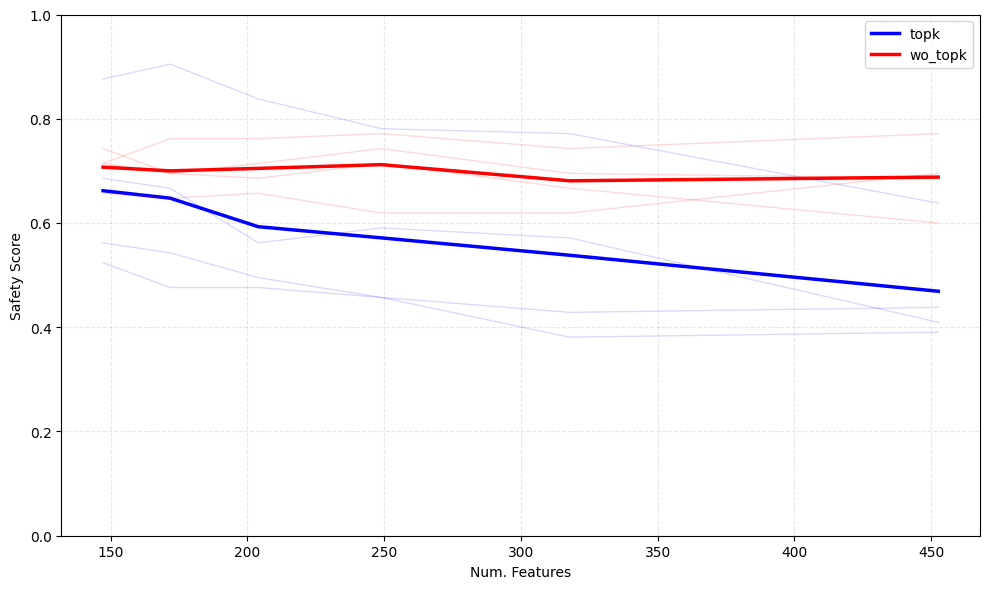

In [33]:
import matplotlib.pyplot as plt

# Example dummy data
# Plot setup
plt.figure(figsize=(10, 6))
colors = {
    'topk': 'blue',
    'wo_topk': 'red',
}
labels = {
    'score1': 'features',
    'score2': 'neurons',
}

for label,scores in combined_scores.items():
    score = scores['refusal']
    color = colors[label]
    
    # Plot all individual runs with low opacity
    for line in score:
        plt.plot(n_feats, line, color=color, alpha=0.15, linewidth=1)
    
    # Plot mean line
    mean = score.mean(axis=0)
    plt.plot(n_feats, mean, color=color, linewidth=2.5, label=label)

# Labels and legend
plt.xlabel("Num. Features")
plt.ylabel("Safety Score")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
print (combined_scores['topk']['refusal'][0])

[0.87619048 0.9047619  0.83809524 0.78095238 0.77142857 0.63809524]
